# Project 1: Digit Classification with KNN and Naive Bayes

## *******PLEASE RUN IN PYTHON 3 KERNEL********

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points 
# and apply this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1

**(1)** Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [ ]:
def P1(num_examples=10):

### STUDENT START ###
    plt.figure(figsize=(10, 10))
    for i in range(10):
        
        #get get the first 10 image arrays in mini_train_data for each digit 0-9
        row = mini_train_data[mini_train_labels==str(i)][:num_examples]
        
        #for each of the 10 image arrays retrieved, plot as a subplot in the 10x10 grid
        for j in range(row.shape[0]):
            plt.subplot(10,num_examples,i*num_examples+j+1)
            plt.xticks([])
            plt.yticks([])
            #reshape each image array to a 2-D square matrix.  Dimensions are 28x28=784
            plt.imshow(row[j].reshape(28,28), cmap = 'gray_r')
            
### STUDENT END ###

P1(10)

### Question 2
**(2)** Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting

In [4]:
def P2(k_values):

### STUDENT START ###
    results = []
    for k in k_values:
        
        #for each value of k, use KNeighborsClassifier() to find the predicted labels
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(mini_train_data, mini_train_labels)
        predicted_labels = model.predict(dev_data)
        
        #calculate accuracy as number of correctly predicted labels divided by dev labels
        accuracy = np.sum(predicted_labels == dev_labels)/dev_labels.size
        
        #ading k and accuracy as a list pair to the results list
        results.append([k, accuracy])
    return results
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
print("Accuracies for each value of k\n", P2(k_values))

Accuracies for each value of k
 [[1, 0.884], [3, 0.876], [5, 0.882], [7, 0.877], [9, 0.875]]


- classification_report() for producing precision, recall, F1 results

In [5]:
#for k=1, print the classification report
model1 = KNeighborsClassifier(n_neighbors=1)
model1.fit(mini_train_data, mini_train_labels)
predicted_labels1 = model1.predict(dev_data)
        
print(classification_report(dev_labels, predicted_labels1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



**ANSWER:** Precision is a measure of how good the model is at minimizing false negatives while Recall measures how good the model is at minimizing false positives.  The F1-score is the weighted average of precision and recall, and measures how good the model is at minimizing the sum of false negatives and false positives.  Therefore F1-score is is the best measure to use for determining the most difficult digit in this case.  The digit with the lowest number score has the highest sum of false positive and false negatives.  According to the table output above, the most difficult digit is the number 8. 

### Question 3
**(3)** Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
import time

def P3(train_sizes, accuracies):

### STUDENT START ###
    times =[]
    for t in train_sizes:
        
        #start time recorded at the beginning of each iteration for amount of time needed
        start_time = time.time()
        
        #partition the train_data and train_labels by first t values
        train_data_fit, train_labels_fit = train_data[:t], train_labels[:t]
        
        #use KNeighborsClassifier() to find the predicted labels
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(train_data_fit, train_labels_fit)
        predicted_labels = model.predict(dev_data)
        
        #calculate accuracy as number of correctly predicted labels divided by dev labels
        accuracy = np.sum(predicted_labels == dev_labels)/dev_labels.size
        
        #amount of time calculated by end time - start time
        time_needed = float(time.time() - start_time)
        
        accuracies.append(accuracy)
        times.append(time_needed)
    return [accuracies, times]


train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3_results = P3(train_sizes, accuracies)

In [7]:
# print results in a nice table:
import pandas as pd

results_table = pd.DataFrame([train_sizes, P3_results[0], P3_results[1]]).T
results_table.columns = ["Training Size", "Accuracy", "Time(s)"]

results_table

### STUDENT END ###

,Training Size,Accuracy,Time(s)
0,100.0,0.702,0.200260
1,200.0,0.791,0.386156
2,400.0,0.811,1.002020
3,800.0,0.866,1.765261
4,1600.0,0.905,3.299525
5,3200.0,0.927,6.630183
6,6400.0,0.939,13.470150
7,12800.0,0.952,26.705977
8,25000.0,0.962,58.852365


### Question 4
**(4)** Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Intercept: [0.83440866]
Coefficient: [[6.83806142e-06]]

Estimated Function: y = 0.83 + 0.00x
Estimated Accuracy at n = 60000 is 1.2447


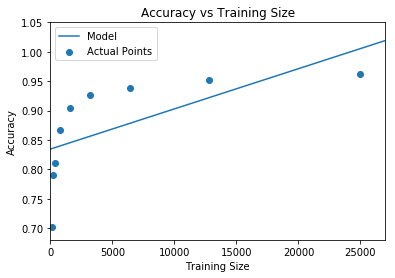

In [8]:
def P4():

### STUDENT START ###
    #retrieve the train_sizes and accuracy columns from the table in #3
    #transform them into 2D array vectors
    ts = results_table['Training Size'].as_matrix()[:, np.newaxis]
    acc = results_table['Accuracy'].as_matrix()[:, np.newaxis]
    
    #fit linear regression model to training sizes and accuracy
    lr = LinearRegression(fit_intercept=True)
    lr.fit(ts, acc)
    print("Intercept:", lr.intercept_)
    print("Coefficient:", lr.coef_)
    print('\nEstimated Function: y = %.2f + %.2fx' %(lr.intercept_, lr.coef_[0]))
    
    #predict accuracy for n=60000
    print("Estimated Accuracy at n = 60000 is %.4f" %lr.predict(np.array([60000])[:, np.newaxis])[0][0])
    
    #plot fitted function to evaluate fit
    x_values = np.linspace(0,30000,10000)
    plt.plot(x_values, lr.predict(x_values[:, np.newaxis]), label = 'Model')
    
    #show actual data points
    plt.scatter(ts, acc, label = 'Actual Points')
    
    #other labels
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.xlim((0, 27000))
    plt.ylim((0.68, 1.05))
    plt.legend(loc="best")
    plt.title("Accuracy vs Training Size")
    
    plt.show()
### STUDENT END ###
P4()


**ANSWER** From the output above for the linear regression model, the prediction of accuracy for n=60000 points is 124%, which is clearly incorrect and also impossible, since accuracy cannot exceed 100%.  In the plot I rendered of the linear model and the data points, we can see clearly that the linear model is not a good fit for the data.  

The actual data points appear to follow a logarithic function, of the form:
Accuracy = log(Training Size) + const.

Therefore, if we apply a log transformation to Training Size, we should see a near linear relationship between Accuracy and log(Training Size).

Intercept: [0.54553691]
Coefficient: [[0.0443709]]

Estimated Function: y = 0.55 + 0.04x
Estimated Accuracy at n = 60000 is 1.0337


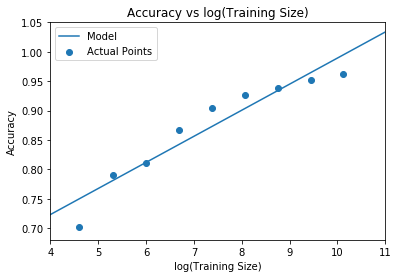

In [9]:
#re-run the code for P4() but with a transformation 

def P4_2():

### STUDENT START ###

    #retrieve the train_sizes and accuracy columns from the table in #3
    #transform them into 2D array vectors
    #however, this time, training size is transformed with np.log()
    ts = np.log(results_table['Training Size'].as_matrix())[:, np.newaxis]
    acc = results_table['Accuracy'].as_matrix()[:, np.newaxis]
    
    #fit linear regression model to training sizes and accuracy
    lr = LinearRegression(fit_intercept=True)
    lr.fit(ts, acc)
    print("Intercept:", lr.intercept_)
    print("Coefficient:", lr.coef_)
    print('\nEstimated Function: y = %.2f + %.2fx' %(lr.intercept_, lr.coef_[0]))
    
    #predict accuracy for n=60000.  
    #Since the function is predicted from log(Training Size) transformation
    #input is log(60000)
    print("Estimated Accuracy at n = 60000 is %.4f" %lr.predict(np.array([np.log(60000)])[:, np.newaxis])[0][0])
    
    #plot fitted function to evaluate fit
    x_values = np.linspace(0,30000,10000)
    plt.plot(x_values, lr.predict(x_values[:, np.newaxis]), label = 'Model')
    
    #show actual data points
    plt.scatter(ts, acc, label = 'Actual Points')
    
    #other labels
    plt.xlabel("log(Training Size)")
    plt.ylabel("Accuracy")
    plt.xlim((4, 11))
    plt.ylim((0.68, 1.05))

    plt.legend(loc="best")
    plt.title("Accuracy vs log(Training Size)")
    
    plt.show()
### STUDENT END ###
P4_2()

We see from this plot that the logarithmic transformation applied to the Training Size variable appears to have linearized the data points significantly.  the regression line is a much better fit around most of the points, but is stil quite far from the point (Training Size = 10, Accuracy = 0.702).  

The prediction for the accuracy at n=60000 is 103%, which is still not correct since it exceeds 100%, but is much closer to the true value than before the transformation is applied. 

### Question 5
**(5)** Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [10]:
### STUDENT START ###
    
#create 1-NN model using the entire training set
model = KNeighborsClassifier(n_neighbors=1)
model.fit(mini_train_data, mini_train_labels)
    
#find the predicted labels from the dev data
predicted_labels_5 = model.predict(dev_data)
    
#apply confusion matrix to predicted labels and dev labels
CM = confusion_matrix(dev_labels, predicted_labels_5, labels = [str(i) for i in range(10)])
    
print(CM)

### STUDENT END ###

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


**Answer**: In the confusion matrix C, the value C[i][j] represents the number of observations known to be in group i, but predicted to be in group j.  So the most confused pair would be the pair that results in the greatest sum of false negatives and false positives, or the pair (i,j), off diagonal, where C[i][j]+C[j][i] is greatest.  The following code allows me to find the most confused pair:

In [11]:
### STUDENT START ###

#create a unique list of all off diagonal pairs of (i,j)
pairs = [(i, j) for i in range(10) for j in range(i, 10) if i!=j]

#calculate CM[i][j]+CM[j][i] for all pairs (i,j)
confused_counts = [CM[p[0]][p[1]]+CM[p[1]][p[0]] for p in pairs]

#finding the maximum value(s) of CM[i][j]+CM[j][i].  
max_values = [i for i in confused_counts if i==max(confused_counts)]

#printing the maximum value(s) to check their uniqueness
print(max_values)

#finding the pair (i,j) that corresponds to the max value
most_confused = pairs[confused_counts.index(max(confused_counts))]
print(most_confused)

### STUDENT END ###

[14]
(4, 9)


From this output, we see that the most confused pair from the dev set, using the 1-NN model built from the mini train set, is the numbers 4 and 9.  There are 11 examples where a true 4 is predicted as a 9 and 3 examples where a true 9 is predicted as a 4.  These examples are displayed below:

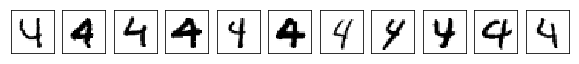

In [12]:
### STUDENT START ###

#True 4, Predicted as 9
plt.figure(figsize=(10, 10))
wrong9 = dev_data[(predicted_labels_5 == '9') & (dev_labels == '4')]

for i in range(wrong9.shape[0]):
    plt.subplot(1,wrong9.shape[0],i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wrong9[i].reshape(28,28), cmap = 'gray_r')
    
### STUDENT END ###

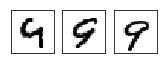

In [13]:
### STUDENT START ###

#True 9, Predicted as 4
plt.figure(figsize=(10, 10))
wrong4 = dev_data[(predicted_labels_5 == '4') & (dev_labels == '9')]

for i in range(wrong4.shape[0]):
    plt.subplot(1,wrong9.shape[0],i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wrong4[i].reshape(28,28), cmap = 'gray_r')
    
### STUDENT END ###

### Question 6
**(6)** A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [14]:
### STUDENT START ###
import math

#define 3x3 convolution matrix where
#values are weights calulated from a 2D Gaussian function, sigma = 1
convolution_matrix = np.zeros(9).reshape(3,3)
indices1 = [(i, j) for i in range(3) for j in range(3)]
for index in indices1:
    
    #for each index find x and y, distances from the center at position (1,1)
    x = abs(index[0] - 1)
    y = abs(index[1] - 1)
    
    #use x and y as inputs in the gaussian function, sigma = 1
    g = 1/(2*math.pi)*math.exp(-(x**2+y**2)/2)
    
    convolution_matrix[index[0]][index[1]] = g

convolution_matrix = convolution_matrix/np.sum(convolution_matrix)

convolution_matrix
### STUDENT END ###

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

**ANSWER**: The convolution matrix defined is a matrix of constant values.  Every value is calculated from a Gaussian function, with sigma 1, based on the position from the center.  The convolution matrix has also been normalized so that the sum of all values is 1.  

Next, the code below defines the function (P6) of applying a filter to the entire image. The filter will be applied as follows:

- for each pixel in the image array, extract the 3x3 submatrix that consists of itself and 8 directly adjacent neighbors
- multiply the submatrix by the convolution_matrix, using element by element multiplication, then take the sum of the product matrix.  This result is the new smoothed pixel value.  This creates a weighted average, where the center value is given the greatest weight and the outer values are weighted less depending on how far they are from the center. 
- PLEASE NOTE: I specifically do not calculated for any pixel in the outer border, since they are all most likely white, but also they do not have all 8 neighbors.  

In [15]:
### STUDENT START ###

#using the above convolution matrix define a function that calculates 
#each new pixel value for all values in an image. 

def P6(img):
    
    #function takes a 1-D image matrix, first reshape to 2-D
    img = img.reshape((28,28))
    
    #copy the image matrix. image matrix will be unchanged, 
    #copy used to contain all new calculated values
    new_img = np.copy(img)
    
    #create all indices for calculation.  The outer border is not included
    indices = [(i, j) for i in range(1,27) for j in range(1,27)]
    
    for index in indices:
        
        #define 3x3 submatrix consisting of pixel and all directly adjacent neighbors:
        submatrix = img[index[0]-1:index[0]+2,index[1]-1:index[1]+2]
        
        #weighted pix value calculation
        new_pixel = np.sum(submatrix*convolution_matrix)
        
        #store in new image
        new_img[index[0]][index[1]] = new_pixel
    
    return new_img.flatten()

### STUDENT END ###

Before applying the Gaussian blur filter to the train and dev sets, I test the filter on an image of every digit below, where the original image is on the right and the blurred image is on the left:

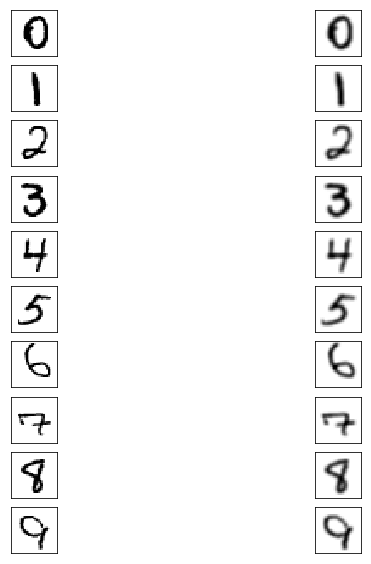

In [16]:
### STUDENT START ###
# testing the bluring of an image every every number:

plt.figure(figsize=(10, 10))
for i in range(10):
        #retrieve one image of every number
        image = mini_train_data[mini_train_labels==str(i)][0]
        plt.subplot(10,2,i*2+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image.reshape(28,28), cmap = 'gray_r')
        blur = P6(image)
        plt.subplot(10,2,i*2+2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(blur.reshape(28,28), cmap = 'gray_r')
### STUDENT END ###

Next, I apply the filter to the dev and and mini train data sets and calculate the accuracy for each of the following scenarios:

1. preprocess the training data but not the dev data
2. preprocess the dev data but not the training data
3. preprocess both training and dev data

In [17]:
### STUDENT START ###

filtered_train = np.apply_along_axis(P6, 1, mini_train_data)
filtered_dev = np.apply_along_axis(P6, 1, dev_data)

def calc_acc(train_set, dev_set):
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(train_set, mini_train_labels)
    predicted_labels = model.predict(dev_set)
    accuracy = np.sum(predicted_labels == dev_labels)/dev_labels.size
    return accuracy

print("0. Accuracy for mini train data and dev data: %.4f" \
      %calc_acc(mini_train_data, dev_data))
print("1. Accuracy for preprocessed training data but not dev data: %.4f" \
      %calc_acc(filtered_train, dev_data))
print("2. Accuracy for preprocessed dev data but not training data: %.4f" \
     %calc_acc(mini_train_data, filtered_dev))
print("3. Accuracy for preprocessed dev data but not training data: %.4f" \
     %calc_acc(filtered_train, filtered_dev))

### STUDENT END ###

0. Accuracy for mini train data and dev data: 0.8840
1. Accuracy for preprocessed training data but not dev data: 0.9060
2. Accuracy for preprocessed dev data but not training data: 0.8680
3. Accuracy for preprocessed dev data but not training data: 0.9010


From this output, we see that prepossing the training data always results in higher accuracy, but prepossing the dev data alone does not improve the accuracy but may actually cause the accuracy to decrease.  The reasoning behind this may be that blurring the training data allows for a wider range of acceptance for what images constitute as an image of each class.  In the above cells, I tested my simple gaussian blur on every single digit, and I noticed that the outlines of the digits become wider after the blurring has occurred.  This leads me to believe that by blurring the training data, this increases the model's ability to recognize a number of a certain class, because the blur the training images allows there to be more ways for a new test image, which has clearer and more confined pixels, to match a training image.  However, in the opposite scenario, if only the dev data is blurred, this could decrease the accuracy since the model is training with images that are confined to fewer pixels. Therefore, blurring the training set is ultimately the more advantageous move.  

### Question 7

**(7)** Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [18]:
### STUDENT START ###

#define a function that binarizes the data.  
#This preprocesses pixels by assigning 0 to pixels that have a 0 
# and 1 to pixels that have a non-zero value. 
def binarize_image(img):
    new_img = np.copy(img)
    new_img[img > 0] = 1
    return new_img

#calculate accuracy 
def P7():
    clf = BernoulliNB(alpha = 1)
    binarized_train = np.apply_along_axis(binarize_image, 1, mini_train_data)
    binarized_dev = np.apply_along_axis(binarize_image, 1, dev_data)
    clf.fit(binarized_train, mini_train_labels)
    return 'Accuracy: %.4f' %clf.score(binarized_dev, dev_labels)
P7()

'Accuracy: 0.8090'

For use of MultinomialNB, I used the following code block to determine the thresholds for mapping pixel values to 0, 1, 2.  First, I find the minimum and maximum pixel values for one image of every digit

In [19]:
max_pixel_value = []
min_pixel_value = []
for i in range(10):
    img = mini_train_data[mini_train_labels==str(i)][1]
    max_pixel_value.append(max(img))
    min_pixel_value.append(min(img))
print(max_pixel_value)
print(min_pixel_value)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Given that all example images have pixel values that range from 0 to 1, the following mapping will be used prior to modeling with MultinomialNB:
- pixel value = 0 will be mapped to 0
- pixel value >0 and <= 0.5 will be mapped to 1
- pixel value >0.5 will be mapped to 2.  

In [20]:
#define a function that maps pixel values to 0, 1, 2
def map_image(img):
    new_img = np.copy(img)
    new_img[(img > 0) & (img <= 0.5)] = 1
    new_img[img > 0.5] = 2
    return new_img

#calculate accuracy 
def P7_2():
    clf2 = MultinomialNB(alpha = 1)
    mapped_train = np.apply_along_axis(map_image, 1, mini_train_data)
    mapped_dev = np.apply_along_axis(map_image, 1, dev_data)
    clf2.fit(mapped_train, mini_train_labels)
    return 'Accuracy: %.4f' %clf2.score(mapped_dev, dev_labels)
P7_2()

### STUDENT END ###

'Accuracy: 0.8040'

**ANSWER:** It appears from this result that MultinomialNB does not increase the accuracy when compared to the fit of BernoulliNB.  The majority of the pixels that contain non-zero values have low values, so it appears that the most important attribute of a feature appears to be whether or not the pixel has a non-zero value rather than what value the pixel actually contains.  By adding an additional threshold for values in the mapping to 0, 1, and 2 for the application of the MultinomialNB model, we decrease the probability of pixels that do not meet the 0.5 value threshold, which then decreases model accuracy. 

### Question 8

**(8)** Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [21]:
def P8(alphas):

### STUDENT START ###
    
    # create a pipeline with the BernoulliNB to use in GridSearchCV
    bnb = Pipeline([('classifier', BernoulliNB())])
    
    # binarize mini train data using binarize_image() from (7)
    binarized_train = np.apply_along_axis(binarize_image, 1, mini_train_data)
    
    # apply GridSearchCV to the BernoulliNB model built from binarized training data
    # parameters are included based on warning messages
    gs = GridSearchCV(bnb, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
    gs.fit(binarized_train, mini_train_labels)

    return gs


### STUDENT END ###

#dictionary key for alphas updated to 'classifier__alpha' based on documentation
alphas = {'classifier__alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

nb = P8(alphas)


/Users/diliwang/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/diliwang/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/diliwang/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/diliwang/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/diliwang/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alp

In [22]:
#best alpha
print (nb.best_params_)

{'classifier__alpha': 0.001}


In [23]:
# look at cross-validation results
print(nb.cv_results_['param_classifier__alpha'])
print(nb.cv_results_['mean_train_score'])
print(nb.cv_results_['mean_test_score'])

[0.0 0.0001 0.001 0.01 0.1 0.5 1.0 2.0 10.0]
[0.88600804 0.87775536 0.87475531 0.86975618 0.86500267 0.85725565
 0.85175678 0.84699699 0.81624635]
[0.813 0.821 0.825 0.82  0.818 0.816 0.811 0.805 0.781]


In [24]:
#results for alpha = 0
print("Mean Train Score for alpha = 0: {:.3f}".format(nb.cv_results_['mean_train_score'][0]))
print("Mean Test Score for alpha = 0: {:.3f}".format(nb.cv_results_['mean_test_score'][0]))

Mean Train Score for alpha = 0: 0.886
Mean Test Score for alpha = 0: 0.813


**ANSWER:** The best value for alpha is 0.001. For alpha = 0, the training accuracy is 0.886 and the test accuracy is 0.813.  Since the best value for alpha is closer to 0 than to 1, we expect that the accuracy is a lot better for alpha = 0 than for alpha = 1. That appears to be the case, when we compare the accuracy for alpha = 0 here against the accuracy for alpha = 1 calculated in (7).  Given that the data is binarized with a threshold of 0, the probability of whether or not a pixel has value is the dominant feature in the BernoulliNB model, so we expect that likelihood of a feature is dominated by the probability of the feature rather than the conditional probability of the feature on the set of features.  For this reason, we expect little or no smoothing would give more accurate results, so best alpha should be close to 0. 

### Question 9

**(9)** Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

GaussianNB Accuracy: 0.5930


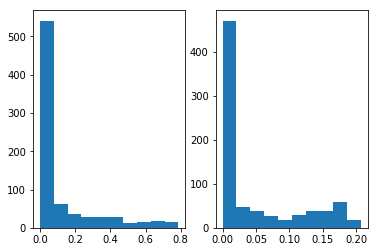

In [25]:
def P9():

### STUDENT START ###

    #fit mini_train_data using GaussianNB and calculate accuracy on dev_data
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    predicted_labels = gnb.predict(dev_data)
    print('GaussianNB Accuracy: %.4f' %np.mean(predicted_labels == dev_labels))
    
    #examining the parameters
    plt.subplot(1,2,1)
    plt.hist(gnb.theta_[7])
    plt.subplot(1,2,2)
    plt.hist(gnb.sigma_[7])
    

P9()

**ANSWER:** From the output above, we see that the accuracy for the GaussianNB model is extremely low.  I also plotted histograms of theta_, the mean of each feature per class, and sigma_, the variance of each figure per class, for one class.  I also varied the class argument to examine the histograms of these parameters across all the classes. 

Below, I applied a quick fix to increase the accuracy of the GaussianNB model so that it is comparable to BernoulliNB.  I varied the var_smoothing parameter with various numbers to maximize the accuracy.

GaussianNB Accuracy: 0.8210


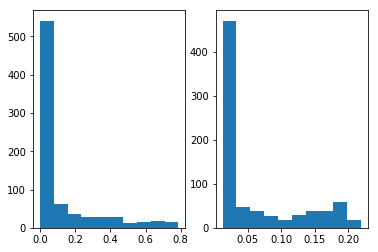

In [26]:
#Applying a fix to increase accuracy

def P9_2():
    
    #fit mini_train_data using GaussianNB and calculate accuracy on dev_data
    gnb2 = GaussianNB(var_smoothing=0.06)
    gnb2.fit(mini_train_data, mini_train_labels)
    predicted_labels = gnb2.predict(dev_data)
    print('GaussianNB Accuracy: %.4f' %np.mean(predicted_labels == dev_labels))
    
    #examining the parameters
    plt.subplot(1,2,1)
    plt.hist(gnb2.theta_[7])
    plt.subplot(1,2,2)
    plt.hist(gnb2.sigma_[7])
    

P9_2()

### STUDENT END ###

According to the documentation on GaussianNB, it appears that the var_smoothing parameter increases the variance of all features per class.  Without smoothing, the pixels with low values that are far from the mean pixel value have very low probability. However, we know from questionn 8 that BernoulliNB accuracy depends on whether or not a pixel has a non-zero value rather than the value contained by the pixel.  The var_smoothing parameter increases the variance so that the probability of low value pixels increase, which in turn increases the probability that dev images with non-zero values in the same pixels are recognized as belonging to the same class.  This then increases the accuracy of the GaussianNB model. 

### Question 10

**(10)** Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

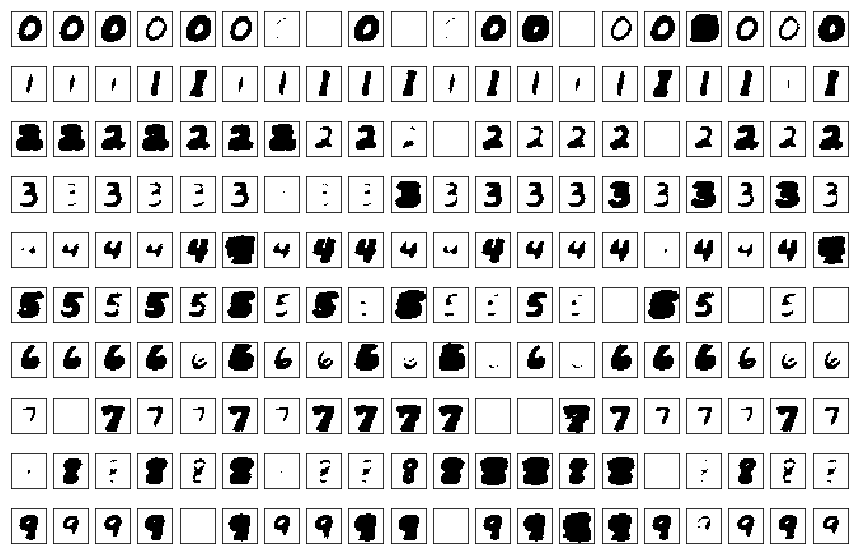

In [27]:
def P10(num_examples):

### STUDENT START ###

    plt.figure(figsize=(15, 10))

    #fit BernoulliNB model using the mini train data
    bnb = BernoulliNB(alpha = 0.001)
    
    #call the binarize_image function from (7) to process train_data
    binarized_train = np.apply_along_axis(binarize_image, 1, mini_train_data)
    bnb.fit(binarized_train, mini_train_labels)
    
    #for each feature, extract the probability per pixel matrix
    for i in range(10):
        feature_prob = np.exp(bnb.feature_log_prob_)[i]
        
        #create num_example images for each class
        for j in range(num_examples):
            #image is initially created with 0 value in every pixel
            img=np.zeros(784)
            
            #np.random.rand() generates probability from [0,1] uniform distribution per pixel
            #if probability is less than that from the the feature probability matrix, pixel turne on with value 1
            #else pixel is turned off
            img[np.random.rand()<=feature_prob] = 1
            
            #plot in 10 by 20 grid
            plt.subplot(10,20,i*num_examples+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img.reshape(28,28), cmap = 'gray_r')
            

### STUDENT START ###

P10(20)

### Question 11

**(11)** Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [28]:
### STUDENT START ###

#call the binarize_image function from (7) to process mini_train_data and dev_data
binarized_train = np.apply_along_axis(binarize_image, 1, mini_train_data)
binarized_dev = np.apply_along_axis(binarize_image, 1, dev_data)

#Start with generating a BernoulliNB model using binarized mini_train_data
#using best alpha value from (8)
bnb = BernoulliNB(alpha = 0.001)
bnb.fit(binarized_train, mini_train_labels)

#define a function to calculate posterior probability for every image in dev_data:

def calculate_posteriors(img):
    #objective of this function is to return a list of normalized posterior probabilities
    #the list should have 10 values, one for each digit
    #posterior probabilities are calculated as the prior probability x likelihood
    
    #extract prior probabilities
    priors = np.exp(bnb.class_log_prior_)
    
    #extract probability of every pixel
    features_prob = np.exp(bnb.feature_log_prob_)
    
    #define inverse image for likelihood calculation.   
    #this is the total product per pixel of 
    #(probability of every pixel that has value = 1) x (1-probability of every pixel that has value = 0)
    #roughly, the logic is prod(img*features_prob+inverse_img*(1-features_prob))
    inverse_img = np.zeros(784)
    inverse_img[img == 0] = 1
    
    #for every digit, calculate likelihood x prior --> posterior
    posteriors = np.zeros(10)
    for i in range(0, 10):
        likelihood = np.prod(features_prob[i] * img + (np.ones(784) - features_prob[i]) * inverse_img)
        posteriors[i] = likelihood*priors[i]
    
    posteriors /= posteriors.sum()
    
    return posteriors
    
def P11(buckets, correct, total):

    #calculate the list of 10 posterior probabilities for each image in dev set
    dev_posteriors = np.apply_along_axis(calculate_posteriors, 1, binarized_dev)
    
    #for each dev image
    for i in range(len(dev_posteriors)):
        #extract the argmax from each list of posteriors.  
        #argmax represents the class with highest posterior probability
        argmax = np.argmax(dev_posteriors[i])
        #also extract the maximum posterior probability
        max_posterior = np.max(dev_posteriors[i])
        
        #correct prediction is a variable used to store a 0 or 1
        correct_prediction = 0
        
        #check if argmax, the predicted class, matches the dev image label
        #if match, then correct_prediction = 1, else 0.  
        
        if str(argmax) == dev_labels[i]:
            correct_prediction = 1
        else:
            correct_prediction = 0
        
        #add the max posterior prob to the correct bucket
        for j in range(len(buckets)):
            if max_posterior <= buckets[j]:
                total[j] +=1
                #The correct_prediction value is added to the correct count 
                #that with index corresponding to the bucket
                correct[j] += correct_prediction
                break
                
    print(buckets, "<-Buckets")
    print(total, "<- Counts per Bucket")
    print(correct, "<-Correct Counts")

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))
    
    

[0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0] <-Buckets
[0, 31, 67, 59, 46, 62, 33, 43, 659] <- Counts per Bucket
[0, 11, 29, 27, 30, 48, 26, 34, 618] <-Correct Counts
p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  31    accuracy = 0.355
p(pred) <= 0.9990000000000    total =  67    accuracy = 0.433
p(pred) <= 0.9999900000000    total =  59    accuracy = 0.458
p(pred) <= 0.9999999000000    total =  46    accuracy = 0.652
p(pred) <= 0.9999999990000    total =  62    accuracy = 0.774
p(pred) <= 0.9999999999900    total =  33    accuracy = 0.788
p(pred) <= 0.9999999999999    total =  43    accuracy = 0.791
p(pred) <= 1.0000000000000    total = 659    accuracy = 0.938


**Answer:** Based on this output,the model only has a 35.5% accuracy fo posterior probability of 90%, so this is defintely not considered a strongly calibrated classifier. The accuracy does increase as the posterior probability increases, so this appears to be at least a weakly calibrated classifier, since there is some postive correlation between posterior and accuracy. 